In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import make_moons
import numpy as np
import matplotlib.pyplot as plt
import random


In [2]:
random.seed(69)
np.random.seed(69)
torch.manual_seed(69)


# Define dataset
X_np, y_np = make_moons(n_samples=200, noise=0.1)
X = torch.tensor(X_np, dtype=torch.float32)
y = torch.tensor(y_np, dtype=torch.float32).reshape(-1, 1)


### Train everything but the first layer

In [3]:
import torch.functional as F

# Define model
class Simple2LayerNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Simple2LayerNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 2)
        self.fc3 = nn.Linear(2, output_size)
        self.tanh = nn.Tanh()
        
    def forward(self, x):
        x = self.tanh(self.fc1(x))
        x = self.tanh(self.fc2(x))
        x = self.tanh(self.fc3(x))
        return x


In [4]:

# Initialize model, loss function, and optimizer
input_size = 2
hidden_size = 8
output_size = 1
net = Simple2LayerNet(input_size, hidden_size, output_size)
loss_fn = nn.BCEWithLogitsLoss()

# for param in net.fc1.parameters():
#     param.requires_grad = False

    
optimizer = optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr=0.01,weight_decay = 0.00001)


### Warm Start the Variables

In [5]:

# Training loop
num_epochs = 1000
for epoch in range(num_epochs):
    # Forward pass
    outputs = net(X)
    loss = loss_fn(outputs, y)
    
    # Backward pass and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Print loss every 100 epochs
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [100/1000], Loss: 0.4133
Epoch [200/1000], Loss: 0.3270
Epoch [300/1000], Loss: 0.3176
Epoch [400/1000], Loss: 0.3154
Epoch [500/1000], Loss: 0.3145
Epoch [600/1000], Loss: 0.3141
Epoch [700/1000], Loss: 0.3139
Epoch [800/1000], Loss: 0.3138
Epoch [900/1000], Loss: 0.3137
Epoch [1000/1000], Loss: 0.3136


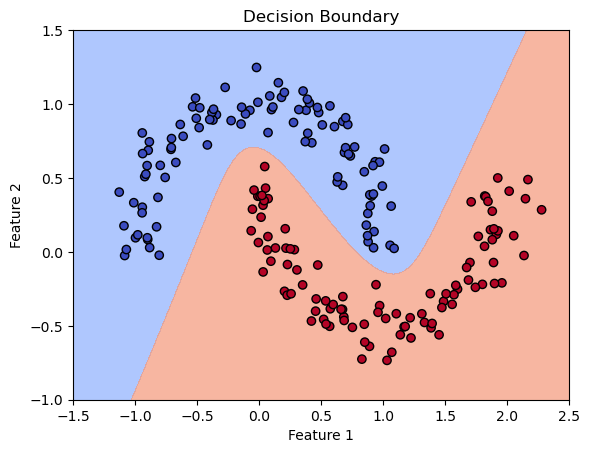

In [6]:

# Plotting decision boundary
with torch.no_grad():
    xx, yy = np.meshgrid(np.linspace(-1.5, 2.5, 100), np.linspace(-1, 1.5, 100))
    grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)
    logits = net(grid).reshape(xx.shape)
    probs = torch.sigmoid(logits)

plt.contourf(xx, yy, probs.numpy(), levels=[0, 0.5, 1], cmap="coolwarm", alpha=0.7)
plt.scatter(X_np[:, 0], X_np[:, 1], c=y_np, edgecolors='k', cmap="coolwarm")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Decision Boundary")
plt.show()

### Train the first layer via proximal gradients
#### First plot the loss landscape wrt the first layer


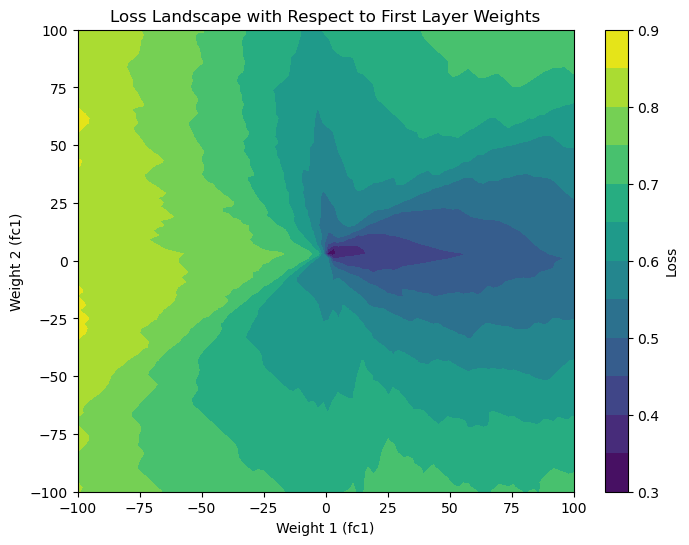

In [9]:
for param in net.parameters():
    param.requires_grad = False

for param in net.fc1.parameters():
    param.requires_grad = True
    

weight1_vals = np.linspace(-100.0, 100.0, 100)  # Range for first weight in `fc1`
weight2_vals = np.linspace(-100.0, 100.0, 100)  # Range for second weight in `fc1`
loss_surface = np.zeros((100, 100))

# Generate loss landscape by evaluating the loss across the grid
for i, w1 in enumerate(weight1_vals):
    for j, w2 in enumerate(weight2_vals):
        with torch.no_grad():
            net.fc1.weight[0, 0] = w1  # First weight in `fc1`
            net.fc1.weight[0, 1] = w2  # Second weight in `fc1`
            outputs = net(X)
            loss_surface[i, j] = loss_fn(outputs, y).item() + 0.001 * (np.abs(w1) + np.abs(w2))

plt.figure(figsize=(8, 6))
plt.contourf(weight1_vals, weight2_vals, loss_surface, levels=10, cmap="viridis")
plt.colorbar(label='Loss')
plt.xlabel('Weight 1 (fc1)')
plt.ylabel('Weight 2 (fc1)')
plt.title('Loss Landscape with Respect to First Layer Weights')
plt.show()

In [57]:

def soft_threshold(x, lambd):
    """Applies soft thresholding to the input tensor x with threshold lambda."""
    return torch.sign(x) * torch.maximum(torch.abs(x) - lambd, torch.tensor(0.0))

def f(t,x):

    learning_rate = 10000
    net.fc1.weight[0, 0].data.fill_(x[0])
    net.fc1.weight[0, 1].data.fill_(x[1])
    net.zero_grad()

    # Enable gradient computation
    net.fc1.weight.requires_grad_(True)
    
    # Forward pass
    outputs = net(X)
    loss = loss_fn(outputs, y)
    
    # Backward pass to compute gradients
    loss.backward()
    
    # Extract gradients
    w1_grad = net.fc1.weight.grad[0, 0].item()
    w2_grad = net.fc1.weight.grad[0, 1].item()

    w1_val = net.fc1.weight[0, 0].detach()
    w2_val = net.fc1.weight[0, 1].detach()
    
    w1_der = - w1_val + soft_threshold(w1_val - learning_rate *  w1_grad,0.001* learning_rate)
    w2_der = - w2_val + soft_threshold(w2_val - learning_rate *  w2_grad,0.001 * learning_rate)
    
    
    return np.array([w1_der,w2_der])



[x1,x2] = f(0, np.array([0.0,0.0]))
print(x1,x2)

-173.66273 119.37018


In [71]:
from scipy.integrate import solve_ivp

x0 = np.array([90.0,90.0])

# Define the time span for the solution
t_span = (0,9)  # Solve from t=0 to t=1
t_eval = np.linspace(0, 9, 100)  # Optional: evaluation points

# Solve the IVP
solution = solve_ivp(f, t_span, x0,  t_eval = t_eval, method='RK45')

# Access the solution
t_values = solution.t
x_values = solution.y





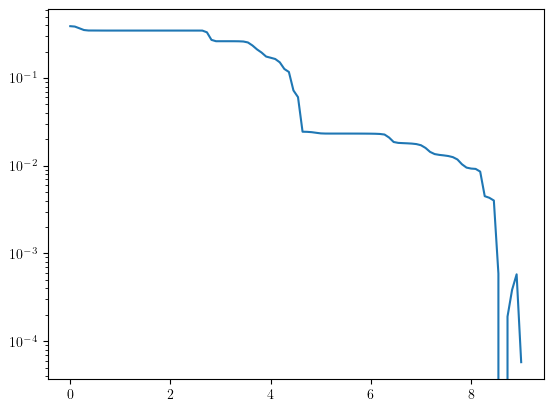

In [72]:
x_values = np.array(x_values)
loss_values = []

for i in range(x_values.shape[1]):
    with torch.no_grad():
        net.fc1.weight[0, 0] = x_values[0,i]
        net.fc1.weight[0, 1] = x_values[1,i]
        outputs = net(X)
        loss_values.append(loss_fn(outputs, y).item() + 0.001 * (np.abs(w1) + np.abs(w2)))

plt.semilogy(t_values, loss_values - np.min(loss_values))



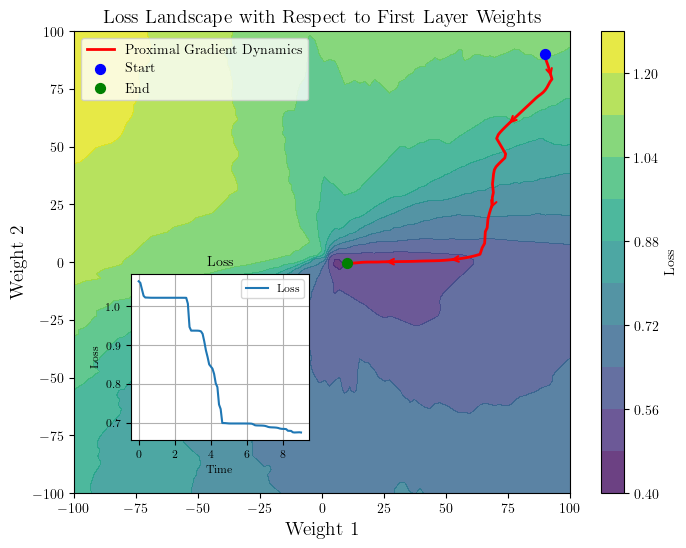

In [74]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

plt.rcParams.update({"text.usetex": True, "font.family": "serif", "font.serif": ["Computer Modern Roman"] })
# Generate loss landscape by evaluating the loss across the grid

weight1_vals = np.linspace(-100.0, 100.0, 100)  # Range for first weight in `fc1`
weight2_vals = np.linspace(-100.0, 100.0, 100)  # Range for second weight in `fc1`
loss_surface = np.zeros((100, 100))

# Generate loss landscape by evaluating the loss across the grid
for i, w1 in enumerate(weight1_vals):
    for j, w2 in enumerate(weight2_vals):
        with torch.no_grad():
            net.fc1.weight[0, 0] = w1  # First weight in `fc1`
            net.fc1.weight[0, 1] = w2  # Second weight in `fc1`
            outputs = net(X)
            loss_surface[i, j] = loss_fn(outputs, y).item() + 0.001 * (np.abs(w1) + np.abs(w2))


plt.figure(figsize=(8, 6))
plt.contourf(weight1_vals, weight2_vals, loss_surface, levels=10, cmap="viridis", alpha=0.8)
plt.colorbar(label='Loss')
plt.xlabel('Weight 1', fontsize=14)
plt.ylabel('Weight 2', fontsize=14)
plt.title('Loss Landscape with Respect to First Layer Weights', fontsize=14)

# Plot trajectory
plt.plot(
    x_values[1, :], x_values[0, :], 
    color='red', linewidth=2, markersize=6, 
    label='Proximal Gradient Dynamics'
)

# Add arrows
for i in range(3, len(x_values[1, :]) - 1, 20):  # Add arrows every 5 steps
    plt.annotate(
        '', 
        xy=(x_values[1, i+1], x_values[0, i+1]), 
        xytext=(x_values[1, i], x_values[0, i]), 
        arrowprops=dict(arrowstyle='->', color='red', lw=1.5)
    )

# Highlight start and end points
plt.scatter(x_values[1, 0], x_values[0, 0], color='blue', s=50, label='Start', zorder=5)
plt.scatter(x_values[1, -1], x_values[0, -1], color='green', s=50, label='End', zorder=5)
plt.legend(loc='upper left', fontsize=10)

# Create inset axes for loss values
axins = inset_axes(plt.gca(), 
                   width="45%", 
                   height="45%", 
                   loc='lower left', 
                   bbox_to_anchor=(0.1, 0.1, 0.8, 0.8),  # Adjust bounding box (x, y, width, height)
                   bbox_transform=plt.gca().transAxes)  
axins.plot(t_values, loss_values, label='Loss')
axins.set_title('Loss', fontsize=10)
axins.set_xlabel('Time', fontsize=8)
axins.set_ylabel('Loss', fontsize=8)
axins.tick_params(axis='both', which='major', labelsize=8)
axins.legend(fontsize=8)

# Add legend and grid
plt.grid()
plt.savefig("loss_landscape_trajectory.pdf", dpi=300, bbox_inches="tight")
plt.show()

In [124]:
def f_new(t, x):
    learning_rate = 100

    weights_reshaped = torch.tensor(x).reshape(net.fc1.weight.shape)
    
    # Fill the entire first layer weight matrix with the input values
    net.fc1.weight.data = weights_reshaped.float()

    
    
    net.zero_grad()
    # Enable gradient computation
    net.fc1.weight.requires_grad_(True)
    
    # Forward pass
    outputs = net(X)
    loss = loss_fn(outputs, y)
    
    # Backward pass to compute gradients
    loss.backward()
    
    # Apply soft-thresholding to the entire weight matrix gradients
    weight_grad = net.fc1.weight.grad
    current_weights = net.fc1.weight.detach()
    
    # Apply proximal gradient descent to the entire weight matrix
    updated_weights = current_weights - learning_rate * weight_grad
    regularized_weights = torch.sign(updated_weights) * torch.clamp(torch.abs(updated_weights) - 0.01 * learning_rate, min=0)
    
    
    # Compute the derivatives (difference between current and regularized weights)
    derivatives = regularized_weights - current_weights    
    return derivatives.numpy().flatten()

In [130]:
# Get the initial flattened weight matrix
x0 = np.random.uniform(-10, 10, size=net.fc1.weight.numel())


# Define the time span for the solution
t_span = (0, 50)
t_eval = np.linspace(0, 100, 100)

# Solve the IVP
solution_new = solve_ivp(f_new, t_span, x0, method='RK45')

# Access the solution
t_values_new = solution_new.t
x_values_new = solution_new.y

# Reshape x_values back to the original weight matrix shape if needed


(20, 384)


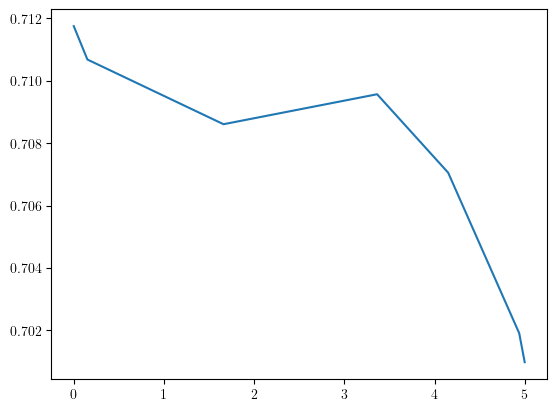

In [131]:
x_values_new = np.array(x_values_new)
print(x_values_new.shape)
loss_values = []

for i in range(x_values.shape[1]):
    with torch.no_grad():
        net.fc1.weight.data = torch.tensor(x_values_new[:,i]).reshape(net.fc1.weight.shape).float()
        outputs = net(X)
        loss_values.append(loss_fn(outputs, y).item() + 0.01 * (np.abs(w1) + np.abs(w2)))

plt.plot(t_values, loss_values)

